## Libraries imports

In [1]:
import pandas as pd
import numpy as np

import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Data imports

In [2]:
data = pd.read_csv("/content/drive/MyDrive/Statapp/data_02.csv")

<ipython-input-2-7ad2a7d11041>:1: DtypeWarning: Columns (6129) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/drive/MyDrive/Statapp/data_02.csv")


Let us gather the useful health-related variables.

Categorical variables:
- RwHOMCAR: indicates whether the Respondent reports any home health care in the reference period. '1' for 'yes', '0' for 'no'.
- RwHIBP: indicates whether the Respondent presents High blood pressure or hypertension. '1' for 'yes', '0' for 'no'.
- RwCANCR: indicates whether the Respondent presents a cancer of any kind. '1' for 'yes', '0' for 'no'.
- RwLUNG: indicates whether the Respondent presents a chronic lung disease. '1' for 'yes', '0' for 'no'.
- RwDIAB: indicates whether the Respondent presents diabete or high blood sugar. '1' for 'yes', '0' for 'no'.
- RwHEART: indicates whether the Respondent presents heart-related problems. '1' for 'yes', '0' for 'no'.
- RwSTROK: indicates whether the Respondent presents stroke or transient ischemic attack. '1' for 'yes', '0' for 'no'.
- RwPSYCH: indicates whether the Respondent presents emotional, nervous or psychiatric problems. '1' for 'yes', '0' for 'no'.
- RwARTHR: indicates whether the Respondent presents arthritis or rheumatism. '1' for 'yes', '0' for 'no'.
- RwBACK: indicates whether the Respondent reports back problems. '1' for 'yes', '0' for 'no'.
- RwDRINK: indicates whether the Respondent drinks any alcool. '1' for 'yes', '0' for 'no'.
- RwSMOKEN: indicates whether the Respondent smokes any cigarette now. '1' for 'yes', '0' for 'no'.
- RwSMOKEV: indicates whether the Respondent ever smoke any cigarette now. '1' for 'yes', '0' for 'no'.
- RwSLFMEM: provides a measure of self reported general rating of memory, from 1 being the best to 5 being the worst rating.
Quantitative variables:
- RwHSPTIM: provides the number of overnight stays at the hospital since the last interview.
- RwNRSTIM: provides the number of overnight nursing home stays since the last interview.
- RwDOCTIM: provides the number of doctor visits since the last interview.
- RwBMI: provides Body Mass Index of the respondent.
- RwAGEY_B: provides the age in years of the respondent.

we will only use these variables for now.

In [96]:
binary_variables = ["HOMCAR","HIBP","DIAB", "CANCR", "LUNG", "HEART","STROK", "PSYCH", "ARTHR", "BACK", "DRINK", "SMOKEN", "SMOKEV"]
non_binary_categorical_variables = ["SLFMEM"]
quantitative_variables = ["HSPTIM","NRSTIM","DOCTIM", "BMI","AGEY_B"]
in_waves = [f"INW{wave}" for wave in range(1, 15)]


In [97]:
health_columns_to_keep = ['R'+str(wave)+var for wave in range(1, 15) for var in binary_variables+non_binary_categorical_variables+quantitative_variables]
health_columns_possible_to_keep = list(set(health_columns_to_keep) & set(data.columns)) # Some column may be missing in the database

health_data = data[["HHIDPN"]+health_columns_possible_to_keep+in_waves]

In [98]:
print(health_data.shape)
health_data.head()

(42233, 281)


,HHIDPN,R13CANCR,R12SMOKEN,R13HIBP,R5HIBP,R2HEART,R4DRINK,R5LUNG,R9AGEY_B,R13HSPTIM,...,INW5,INW6,INW7,INW8,INW9,INW10,INW11,INW12,INW13,INW14
0,1010,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2010,NaN,NaN,NaN,0.0,0.0,1.0,1.0,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2,3010,NaN,NaN,NaN,0.0,0.0,1.0,0.0,72.0,NaN,...,1,1,1,1,1,1,1,0,0,0
3,3020,NaN,0.0,NaN,0.0,0.0,1.0,0.0,69.0,NaN,...,1,1,1,1,1,1,1,1,0,0
4,10001010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,1.0,...,1,1,1,1,1,1,1,1,1,0


In [110]:
def get_wave(df, wave):
  if 1 <= wave and wave < 10:
    columns_of_wave = [col for col in df.columns if col[1] == str(wave) and col[2] not in "01234"]
  elif wave >= 10 and wave < 15:
    columns_of_wave = [col for col in df.columns if col[1:3] == str(wave)]
  else:
    raise Exception("wave must be between 1 and 14 (included).")

  return df.loc[df[f"INW{wave}"]==1, columns_of_wave+["HHIDPN"]]

In [111]:
data_global_health_index = data[["HHIDPN"]+[f"INW{wave}" for wave in range(1,15)]].copy()

In [112]:
for wave in range(1, 15):
  print(f"Wave {wave}:", end=" ")

  # Get data
  data_wave = get_wave(health_data, wave)
  X = data_wave.drop(columns=["HHIDPN"]).values
  print("Data saved", end=" ; ")

  # Preprocessing
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  print("Data scaled", end=" ; ")

  # Imputing missing values
  imputer = IterativeImputer(max_iter=50)
  X_imputed = imputer.fit_transform(X_scaled)
  print("Missing values imputed", end=" ; ")

  # Creating the index
  tSNE = TSNE(n_components=1) # We only take one component because we wish to create an index
  health_index_wave = tSNE.fit_transform(X_imputed)
  print("Health index created", end=" ; ")

  # Storing the index
  data_global_health_index.loc[data_global_health_index[f"INW{wave}"]==1, f"tSNE_GHI{wave}"] = health_index_wave
  print("Health index stored.\n")


Wave 1: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 2: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 3: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 4: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 5: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 6: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 7: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 8: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 9: Data saved ; Data scaled ; Missing values imputed ; Health index created ; Health index stored.

Wave 10: Data saved ; Data scaled ; Missing values impu

In [104]:
  data_global_health_index = data_global_health_index.drop(columns = [f'INW{wave}' for wave in range(1,15)])

In [105]:
data_global_health_index.head()

,HHIDPN,tSNE_GHI1,tSNE_GHI2,tSNE_GHI3,tSNE_GHI4,tSNE_GHI5,tSNE_GHI6,tSNE_GHI7,tSNE_GHI8,tSNE_GHI9,tSNE_GHI10,tSNE_GHI11,tSNE_GHI12,tSNE_GHI13,tSNE_GHI14
0,1010,56.252960,74.083611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,74.491142,-51.357738,-45.037796,-28.164551,-57.849331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3010,39.532166,-65.861031,-77.298355,-119.445435,-96.985619,-75.519569,-105.005005,-111.138397,14.923820,-27.877899,-12.500091,NaN,NaN,NaN
3,3020,103.243729,-9.279924,34.742744,71.442604,61.499371,58.675613,96.004776,48.036003,25.698910,64.546570,26.417677,95.908363,NaN,NaN
4,10001010,-111.478477,51.322151,18.839294,-6.480995,47.144890,-5.612258,-31.872252,-7.575263,117.184349,-29.233362,-21.272423,-28.340797,-51.100956,NaN


In [79]:
data_global_health_index.describe()

,HHIDPN,tSNE_GHI1
count,4.223300e+04,12652.000000
mean,2.888155e+08,-1.083370
std,2.516103e+08,67.780098
min,1.010000e+03,-132.113632
25%,7.311202e+07,-54.940609
50%,2.046370e+08,-1.220091
75%,5.227560e+08,52.964485
max,9.597380e+08,130.527908


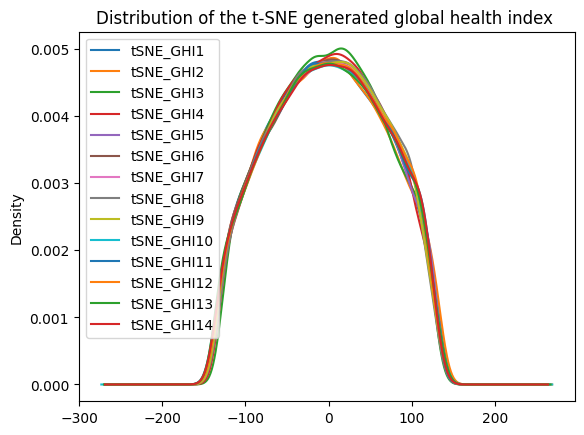

In [60]:
data_global_health_index.drop(columns=["HHIDPN"]).plot.density()
plt.title("Distribution of the t-SNE generated global health index ")
plt.show()

## Comparison with precedent index

In [58]:
data_GHI = pd.read_csv("/content/drive/MyDrive/Statapp/data_only_health_index_2.csv")
data_GHI.head()

,HHIDPN,index_2_w1,index_2_w2,index_2_w3,index_2_w4,index_2_w5,index_2_w6,index_2_w7,index_2_w8,index_2_w9,index_2_w10,index_2_w11,index_2_w12,index_2_w13,index_2_w14
0,1010,0.333088,-3.698928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,0.246520,0.255046,0.213209,0.307378,0.312587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3010,0.363632,0.431329,0.335114,0.320731,0.323663,0.330785,0.364091,0.318365,0.320656,0.257284,0.158740,NaN,NaN,NaN
3,3020,0.437208,0.334530,0.390284,0.420346,0.378833,0.235120,0.149134,0.304341,0.309083,0.276126,0.142465,-0.066251,NaN,NaN
4,10001010,0.411677,0.299593,0.321996,0.270861,0.300019,0.294110,0.307931,0.287869,0.269260,0.308847,0.227056,0.275555,0.271741,NaN


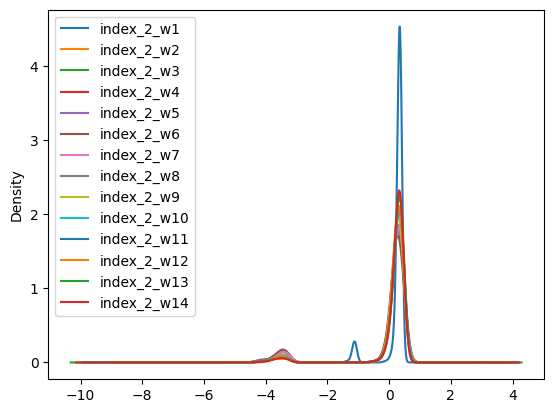

In [59]:
data_GHI.drop(columns=["HHIDPN"]).plot.density()
plt.show()